# Airbnb Quality Prediction

## Loading & Preparing

#### Imports and Loading

In [313]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin


In [314]:
data = pd.read_csv("listings.csv")

In [315]:
data.shape[0]

44684

#### Adding new columns

In [316]:
# data['high_rating'] = (data['review_scores_rating'] > 4).astype(int)
data['price_per_guest'] = data['price'] / data['accommodates']
price_bins = [0, 100, 200, 300, 400, 500, np.inf]
price_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
data['price_range'] = pd.cut(data['price'], bins=price_bins, labels=price_labels)
data['avg_availability'] = (data['availability_30'] + data['availability_60'] + data['availability_90']) / 3
data['amenity_count'] = data['amenities'].apply(lambda x: len(x.split(',')))
data['description_length'] = data['description'].apply(lambda x: len(str(x).split()))
data['price_reviews_interaction'] = data['price'] * data['total_reviews']

TypeError: unsupported operand type(s) for /: 'str' and 'int'

#### Seperating Columns

In [303]:
other_features = ["id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", 
                  "host_id", "host_url", "host_thumbnail_url", "host_picture_url", 
                  "license", "calendar_updated", "calendar_last_scraped", "host_listings_count", "host_since", 
                  "host_location", "neighbourhood", "first_review", "last_review", "amenities", "host_neighbourhood", 
                  "host_verifications", "neighbourhood_group_cleansed"]

geo_features = ["latitude", "longitude"]

continuous_features = ["host_acceptance_rate", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", 
                       "review_scores_communication", "review_scores_value", "review_scores_rating"]

nominal_features = ["host_total_listings_count", "accommodates", "bathrooms", "beds", "minimum_nights", 
                    "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights", 
                    "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", 
                    "maximum_nights_avg_ntm", "number_of_reviews", "number_of_reviews_ltm", 
                    "number_of_reviews_l30d", "calculated_host_listings_count",
                    "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", 
                    "calculated_host_listings_count_shared_rooms", "reviews_per_month", "availability_30", 
                    "availability_60", "availability_90", "availability_365"]

categorical_features = ["host_has_profile_pic", "host_identity_verified", "property_type", "room_type", 
                        "has_availability", "instant_bookable", "neighbourhood_cleansed", "host_response_time", "bathrooms_text", "host_is_superhost"]

qualitative_features = ["name", "description", "neighborhood_overview", "host_name", "host_about"] 

target = "price"


#### Converting Columns to Appriopriate Data Type

In [304]:
continuous_features_other = ["host_acceptance_rate", "host_response_rate"]

for column in continuous_features_other:
    data[column] = data[column].astype(str).str.replace('%', '', regex=False).astype(float) / 100

for column in continuous_features:
    data[column] = data[column].astype(str).str.replace('%', '', regex=False).astype(float)

data['price'] = data['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

exclude_columns = ["price"]

for column in nominal_features:
    if column not in exclude_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

data[qualitative_features] = data[qualitative_features].astype(str)

#### Removing Certain Values Not in Current Scrape

In [305]:
data = data[data["source"] == "city scrape"]

## EDA

#### General Dataset

In [43]:
total_missing_rows = data[data.isnull().any(axis=1)].shape[0]

print(total_missing_rows)

21565


In [28]:
num_rows = data.shape[0]
num_columns = data.shape[1]
column_names = data.columns.tolist()
missing_values = data.isnull().sum()
missing_percentage = (missing_values / num_rows) * 100

# Data dimensions
print('Data dimensions:', data.shape)

# Fraction of missing values per feature
perc_missing_per_ftr = data.isnull().sum(axis=0) / data.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Data types of the features with missing values
print('Data types of the features with missing values:')
print(data[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

# Fraction of points (rows) with missing values
frac_missing = sum(data.isnull().sum(axis=1) != 0) / data.shape[0]
print('Fraction of points with missing values:', frac_missing)

Data dimensions: (36550, 75)
Fraction of missing values in features:
host_location                  0.244049
host_response_time             0.110260
host_response_rate             0.110260
host_acceptance_rate           0.108263
host_is_superhost              0.007004
host_neighbourhood             0.209685
neighbourhood                  0.466840
bathrooms                      0.000301
bathrooms_text                 0.000520
bedrooms                       0.002079
beds                           0.003940
price                          0.000274
calendar_updated               1.000000
has_availability               0.008892
first_review                   0.252449
last_review                    0.252449
review_scores_rating           0.252449
review_scores_accuracy         0.253570
review_scores_cleanliness      0.253570
review_scores_checkin          0.253680
review_scores_communication    0.253570
review_scores_location         0.253680
review_scores_value            0.253707
license    

#### Target

In [29]:
print(data["review_scores_rating"].describe())

count    27323.000000
mean         4.794785
std          0.389452
min          1.000000
25%          4.750000
50%          4.910000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64


Text(0, 0.5, 'Number of Reviews')

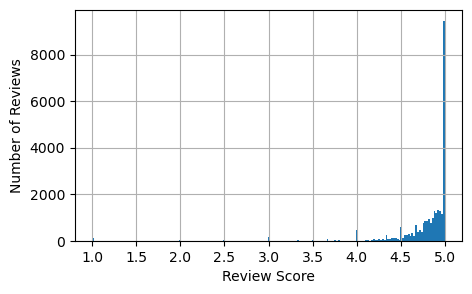

In [30]:
plt.figure(figsize=(5,3))

data["review_scores_rating"].hist(bins = int(np.sqrt(data.shape[0])))
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")

#### Qualitative

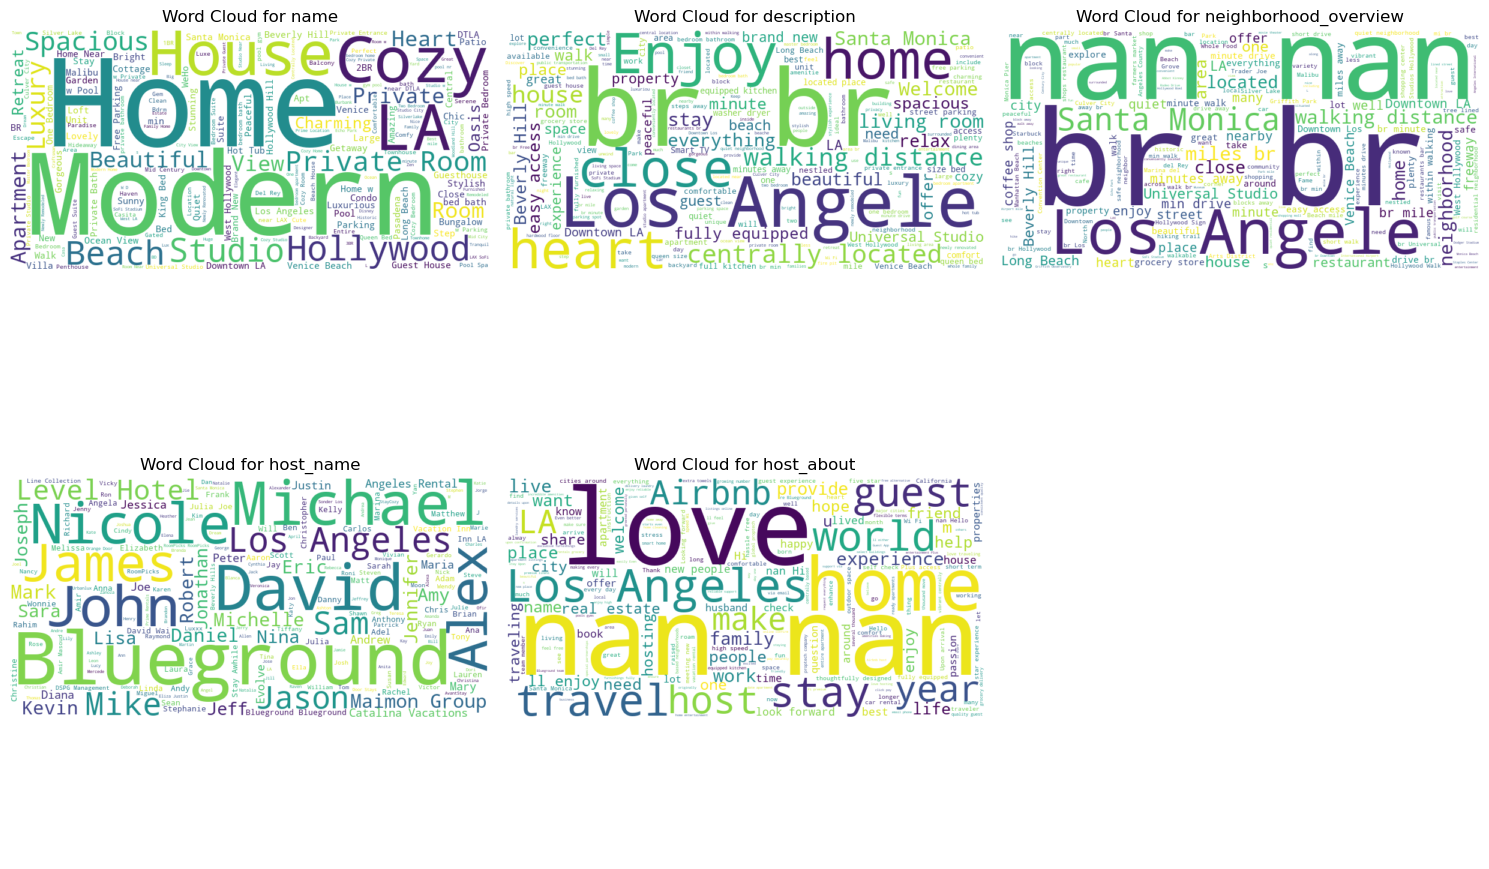

In [31]:
# Create subplots for word clouds
num_features = len(qualitative_features)
num_columns = 3  # Number of plots per row
num_rows = (num_features + num_columns - 1) // num_columns  # Calculate rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate word clouds for each qualitative feature
for i, feature in enumerate(qualitative_features):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data[feature].dropna()))
    
    # Display the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Word Cloud for {feature}')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

#### Target Vs Features

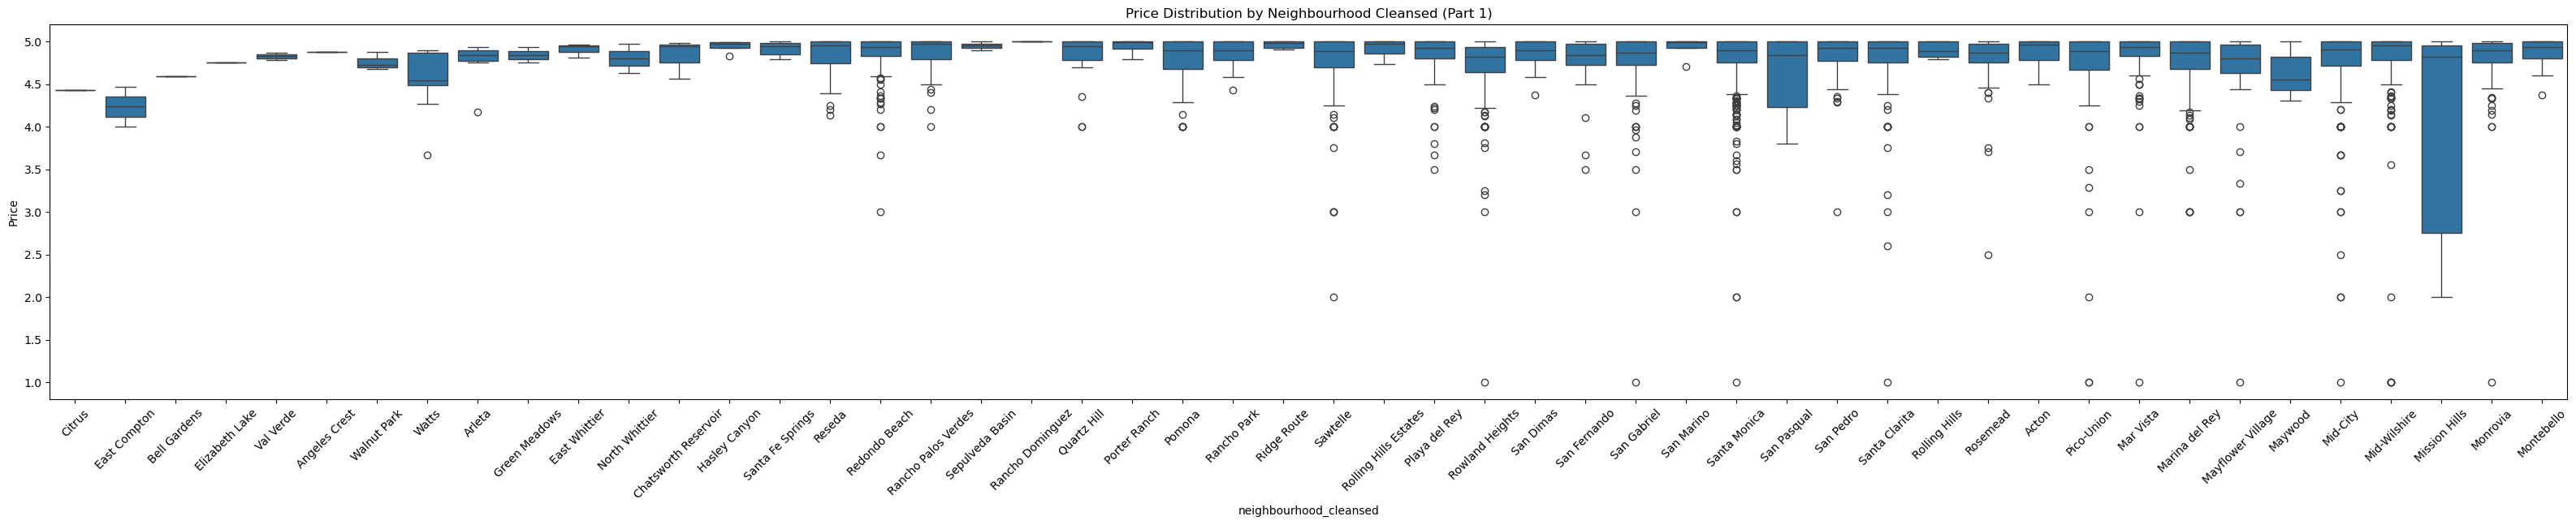

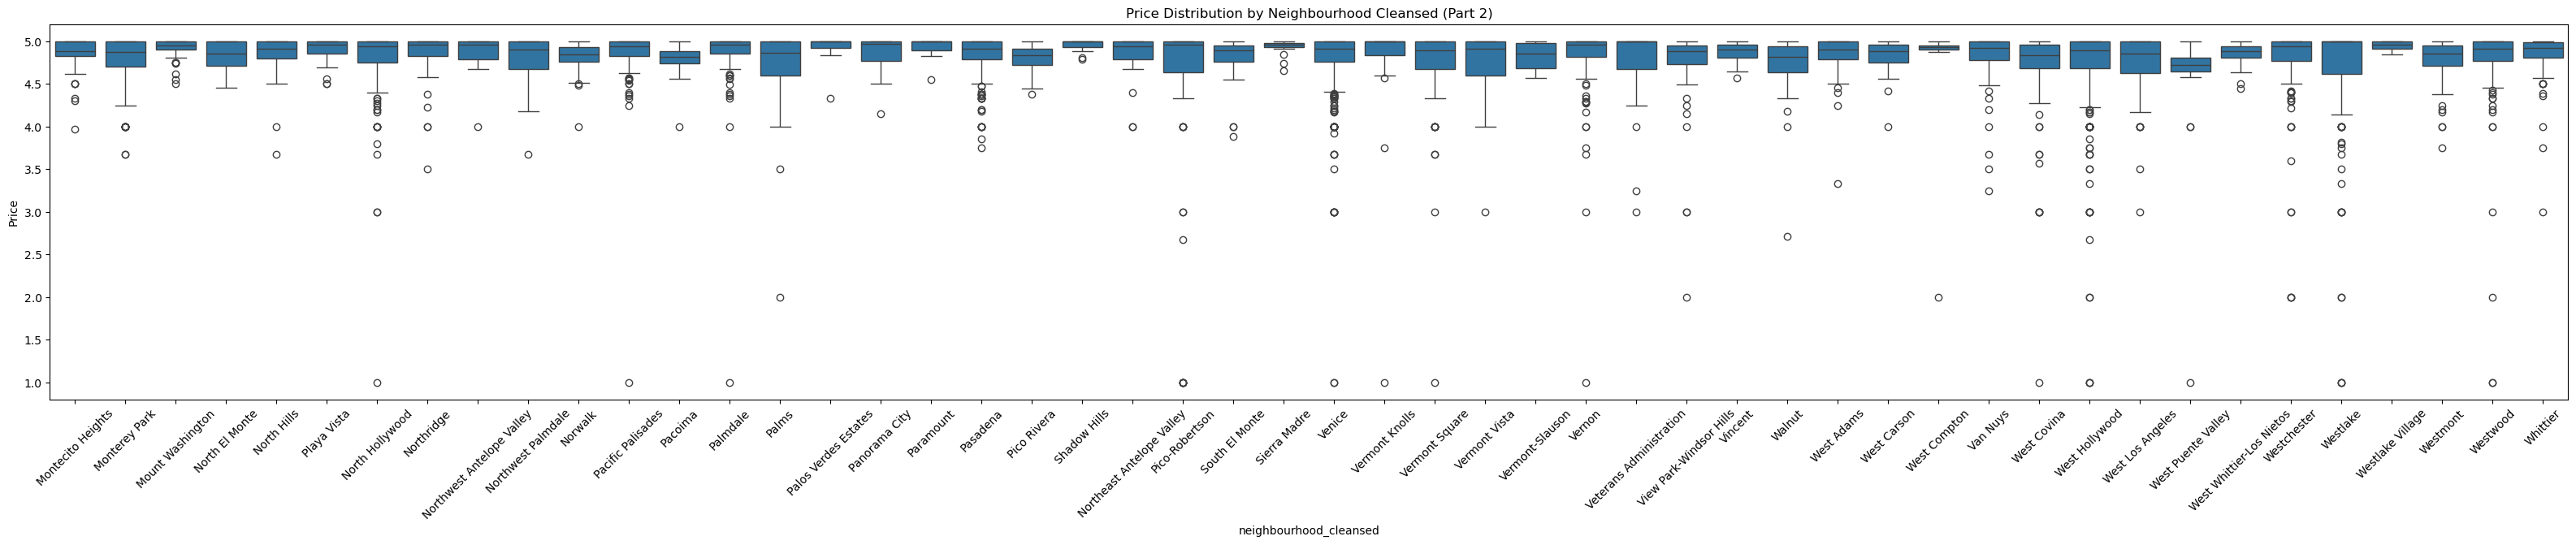

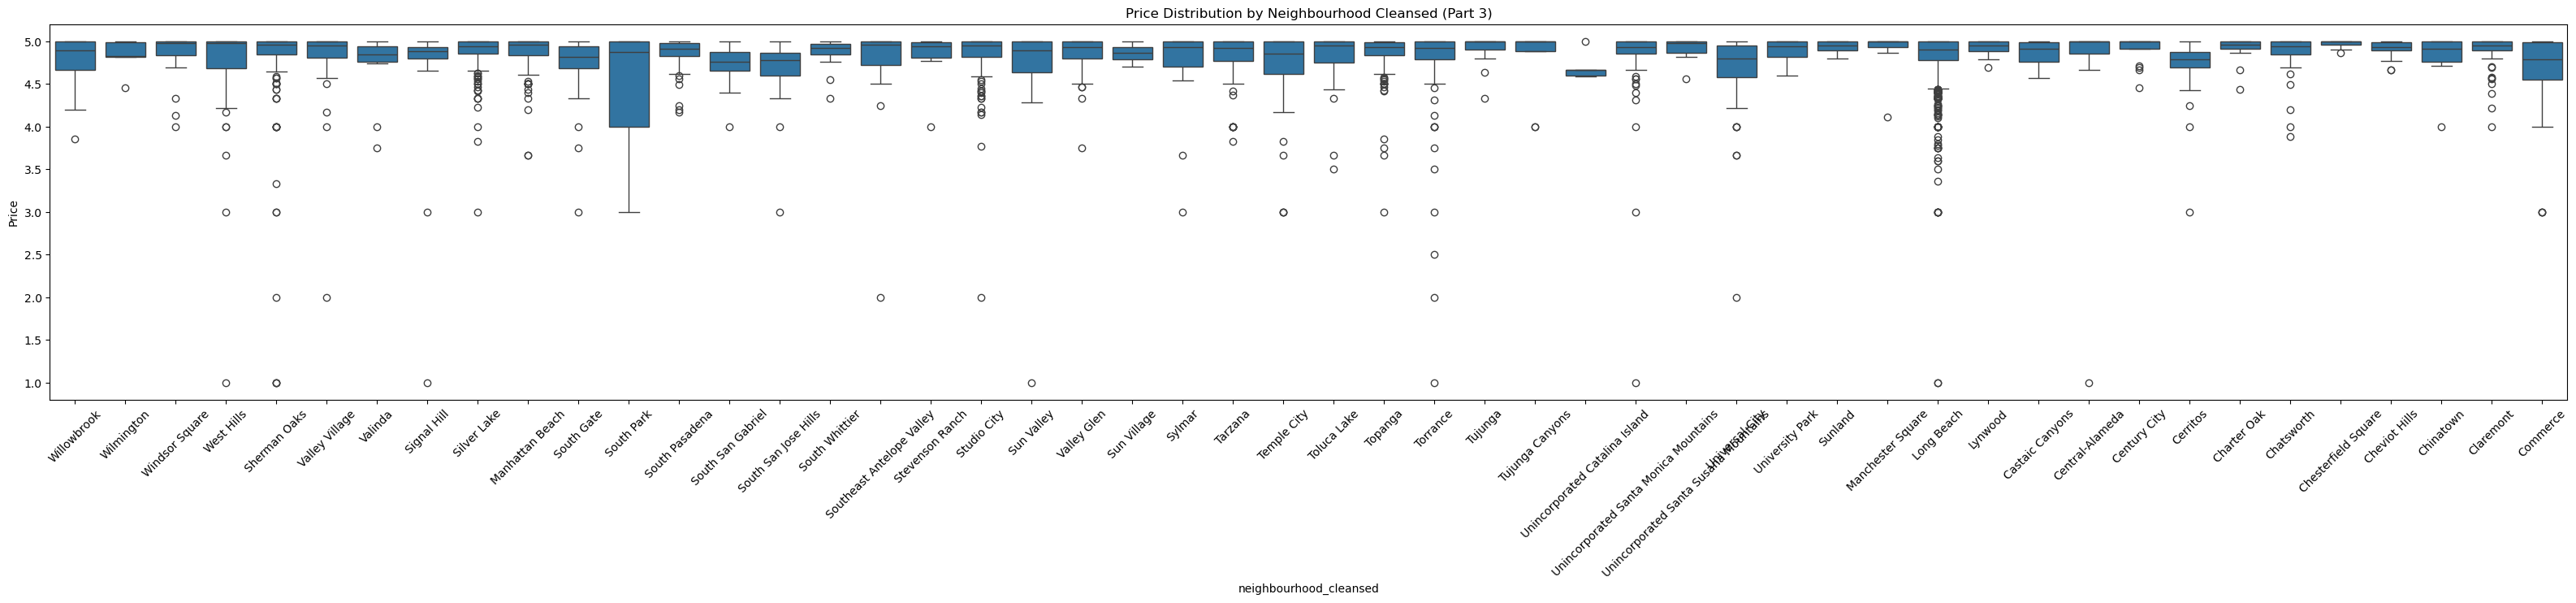

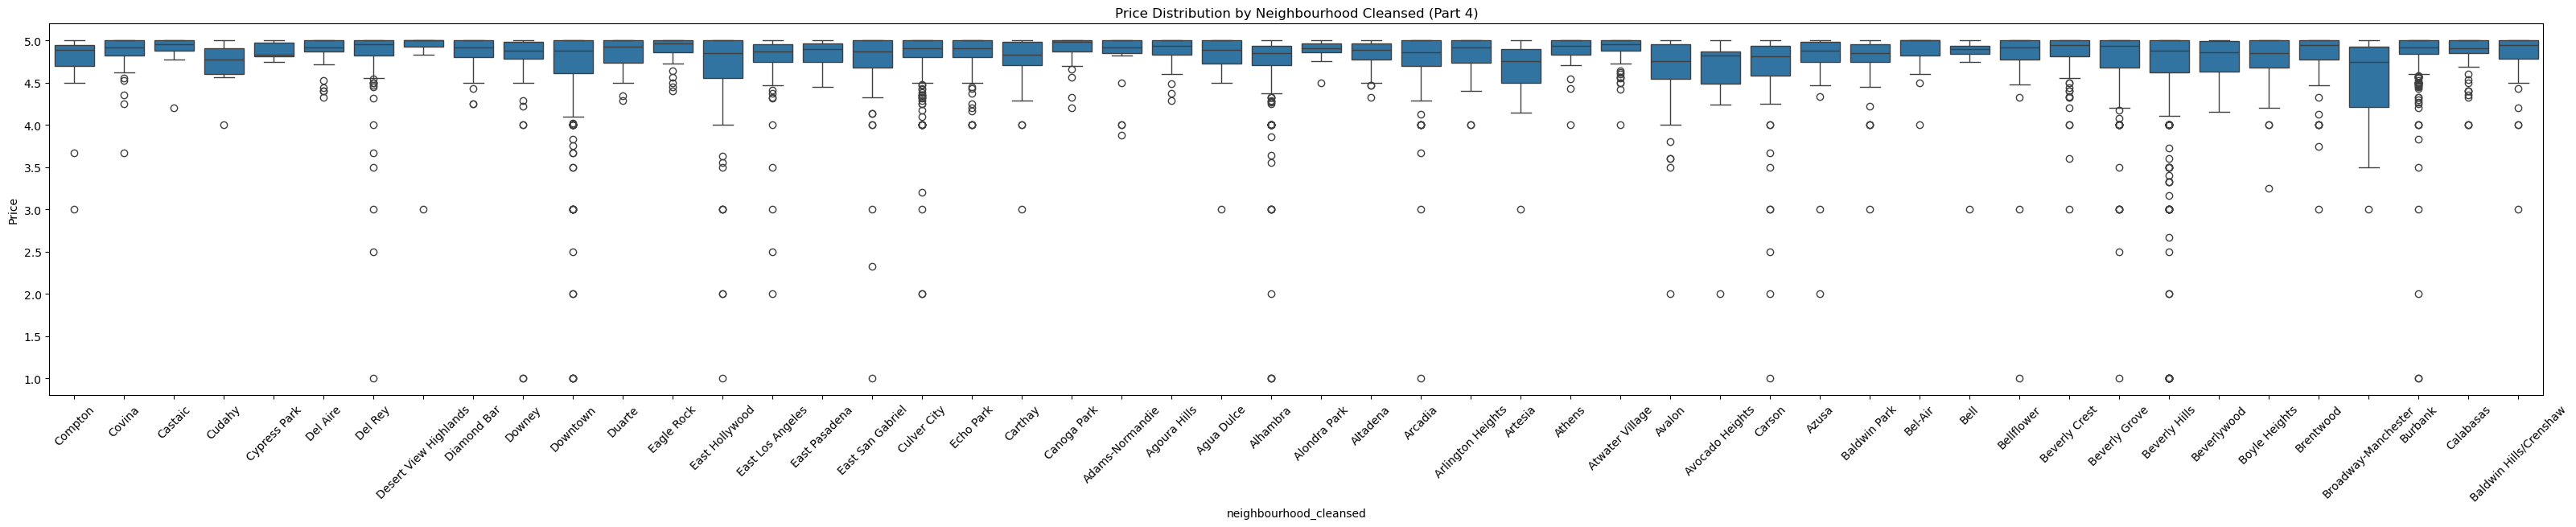

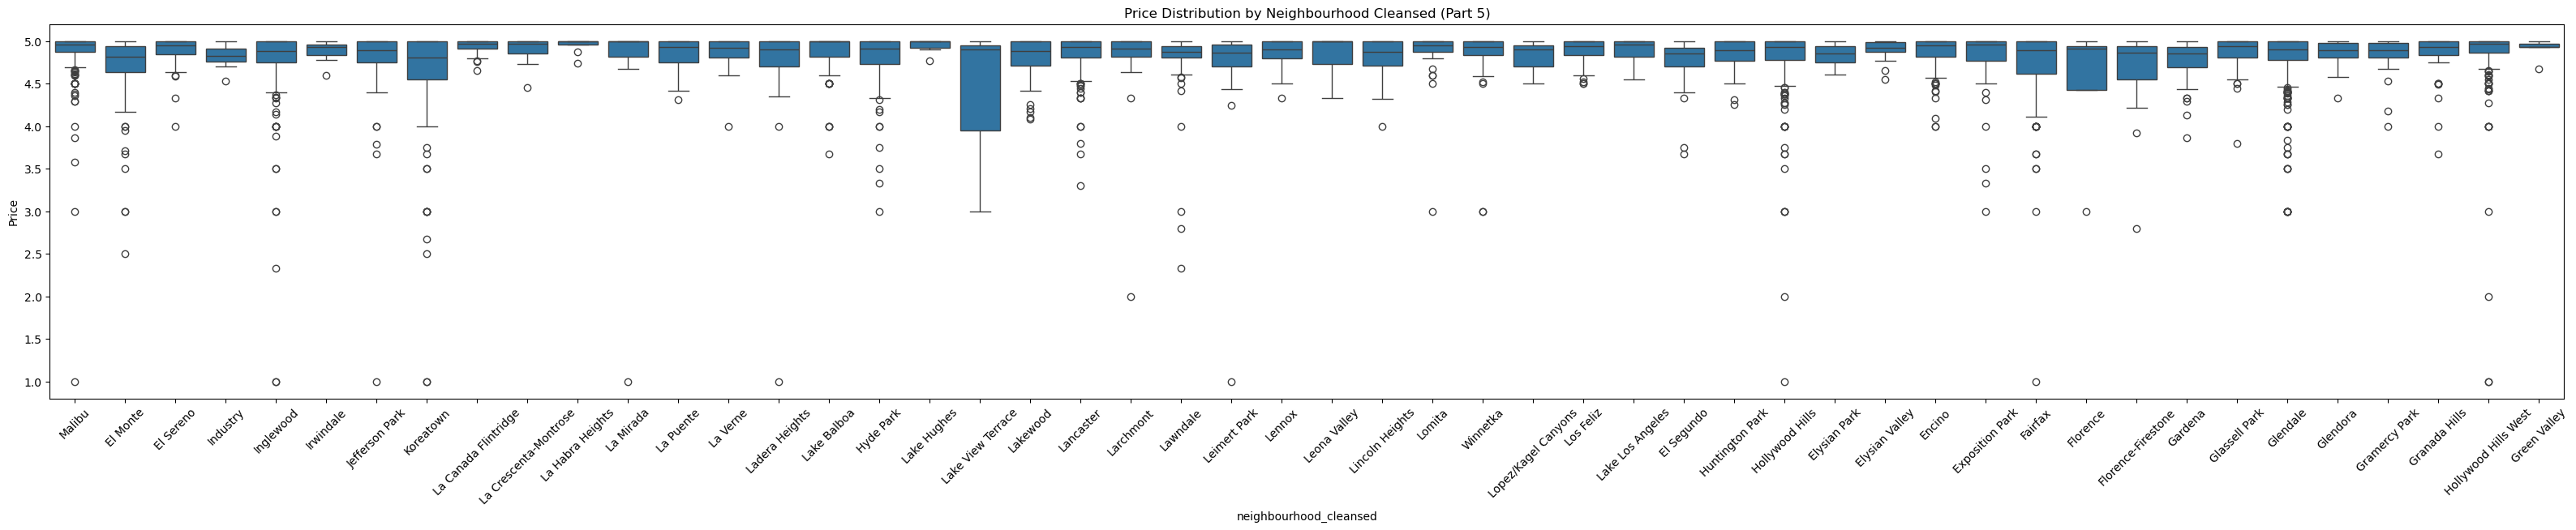

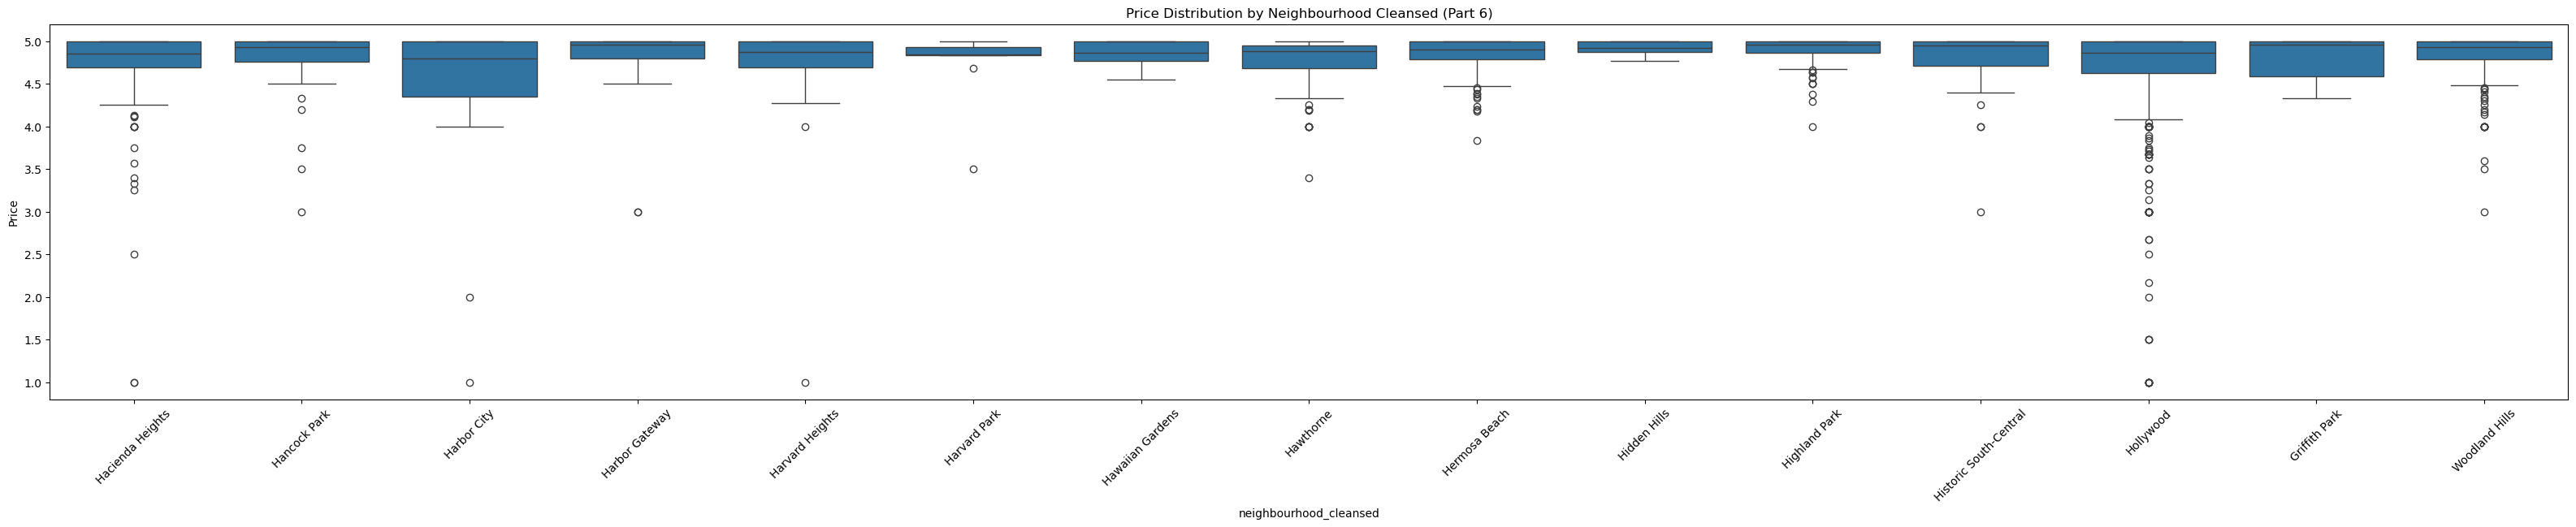

In [32]:
mean_price = data.groupby('neighbourhood_cleansed')['review_scores_rating'].max().reset_index()
mean_price = mean_price.sort_values(by='review_scores_rating')

sorted_neighborhoods = mean_price['neighbourhood_cleansed'].values

neighborhoods_per_plot = 50

for i in range(0, len(sorted_neighborhoods), neighborhoods_per_plot):
    current_neighborhoods = sorted_neighborhoods[i:i + neighborhoods_per_plot]
    filtered_data = data[data['neighbourhood_cleansed'].isin(current_neighborhoods)]
    
    plt.figure(figsize=(40, 6))
    sns.boxplot(data=filtered_data, x='neighbourhood_cleansed', y='review_scores_rating', order=current_neighborhoods)
    plt.title(f'Price Distribution by Neighbourhood Cleansed (Part {i // neighborhoods_per_plot + 1})')
    plt.xticks(rotation=45)
    plt.ylabel('Price')
    plt.show()

Text(0, 0.5, 'Review Scores Rating')

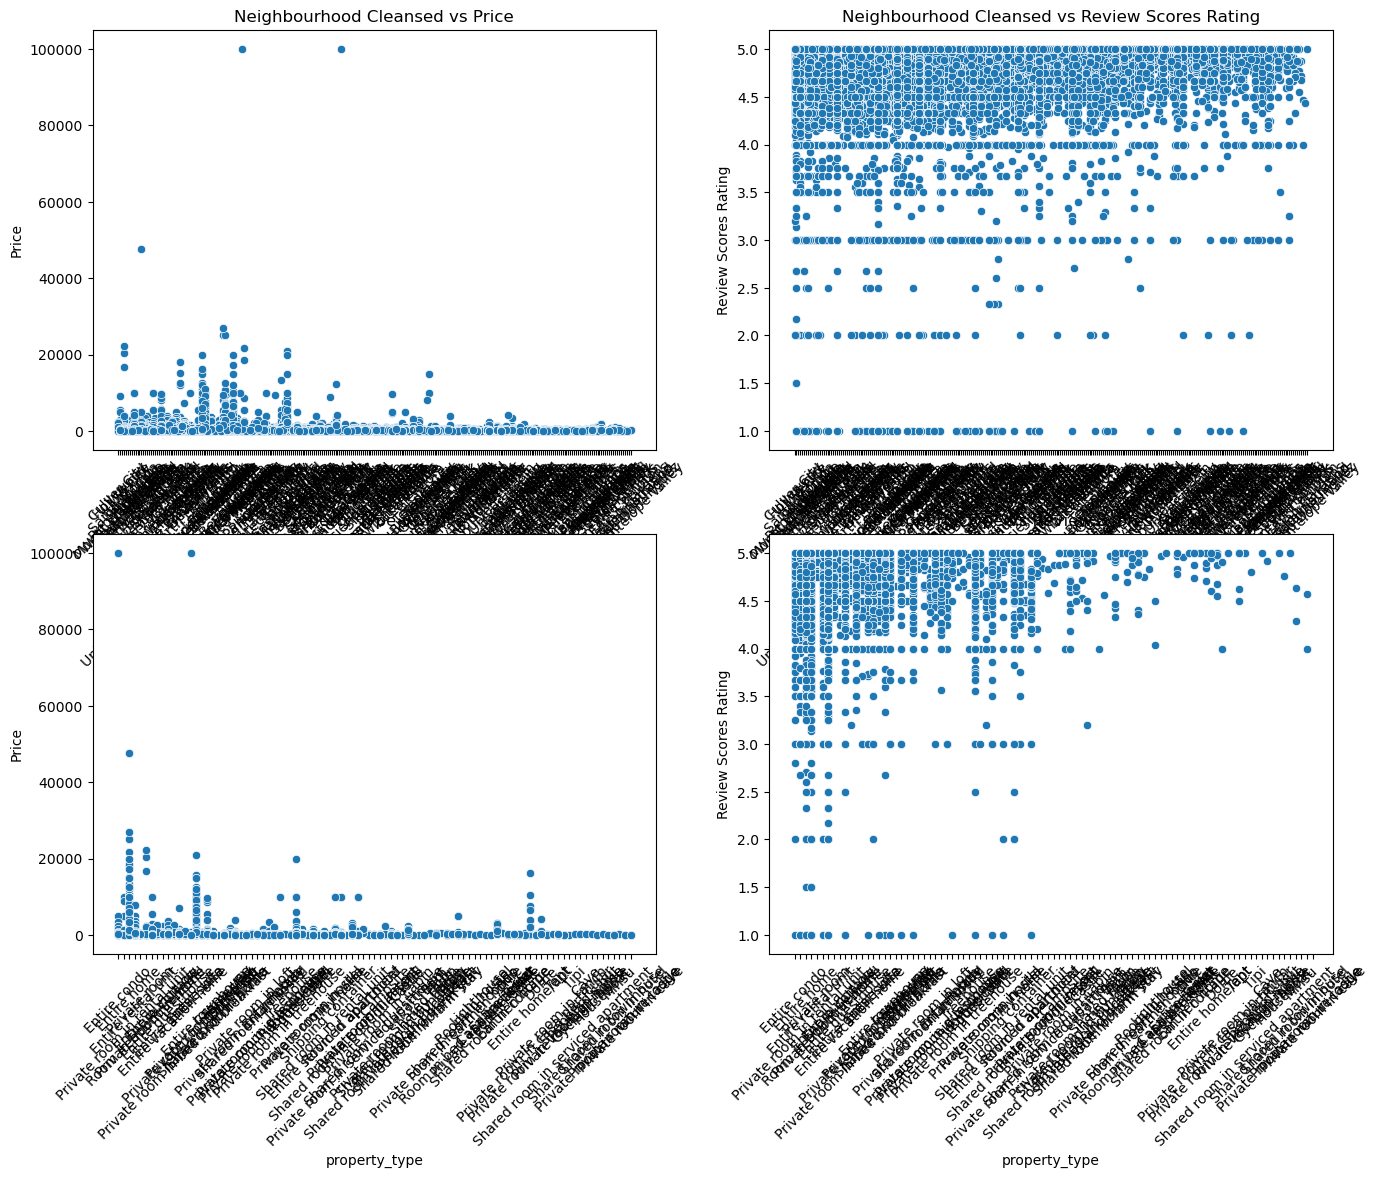

In [33]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='neighbourhood_cleansed', y='price')
plt.title('Neighbourhood Cleansed vs Price')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.ylabel('Price')

plt.subplot(2, 2, 2)
sns.scatterplot(data=data, x='neighbourhood_cleansed', y='review_scores_rating')
plt.title('Neighbourhood Cleansed vs Review Scores Rating')
plt.xticks(rotation=45)
plt.ylabel('Review Scores Rating')

plt.subplot(2, 2, 3)
sns.scatterplot(data=data, x='property_type', y='price')
plt.title('Property Type vs Price')
plt.xticks(rotation=45)
plt.ylabel('Price')

plt.subplot(2, 2, 4)
sns.scatterplot(data=data, x='property_type', y='review_scores_rating')
plt.title('Property Type vs Review Scores Rating')
plt.xticks(rotation=45)
plt.ylabel('Review Scores Rating')

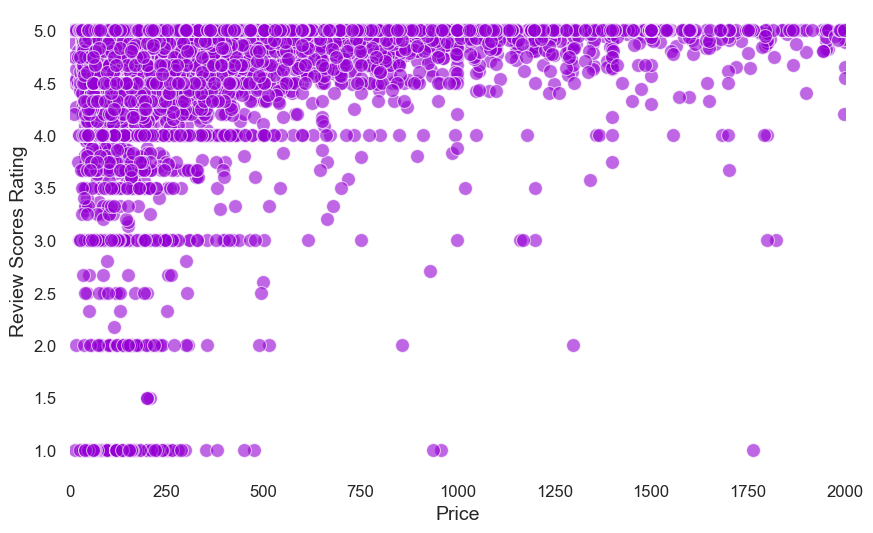

In [28]:
sns.set(style='white')

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=data, x='price', y='review_scores_rating', 
                           color='darkviolet', marker='o', s=100, alpha=0.6)

plt.xlim(0, 2000)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Review Scores Rating', fontsize=14)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Nominal & Continuous

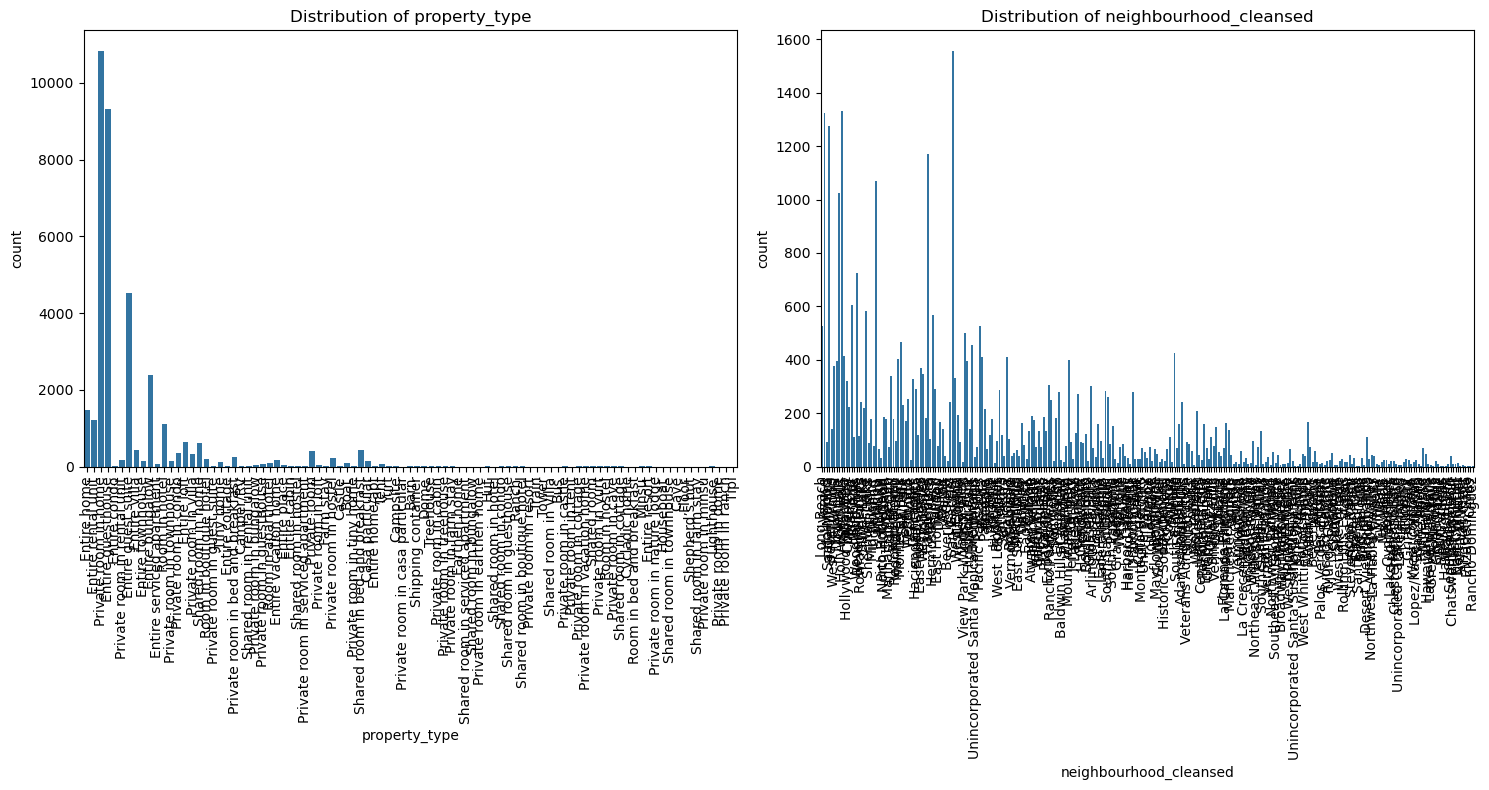

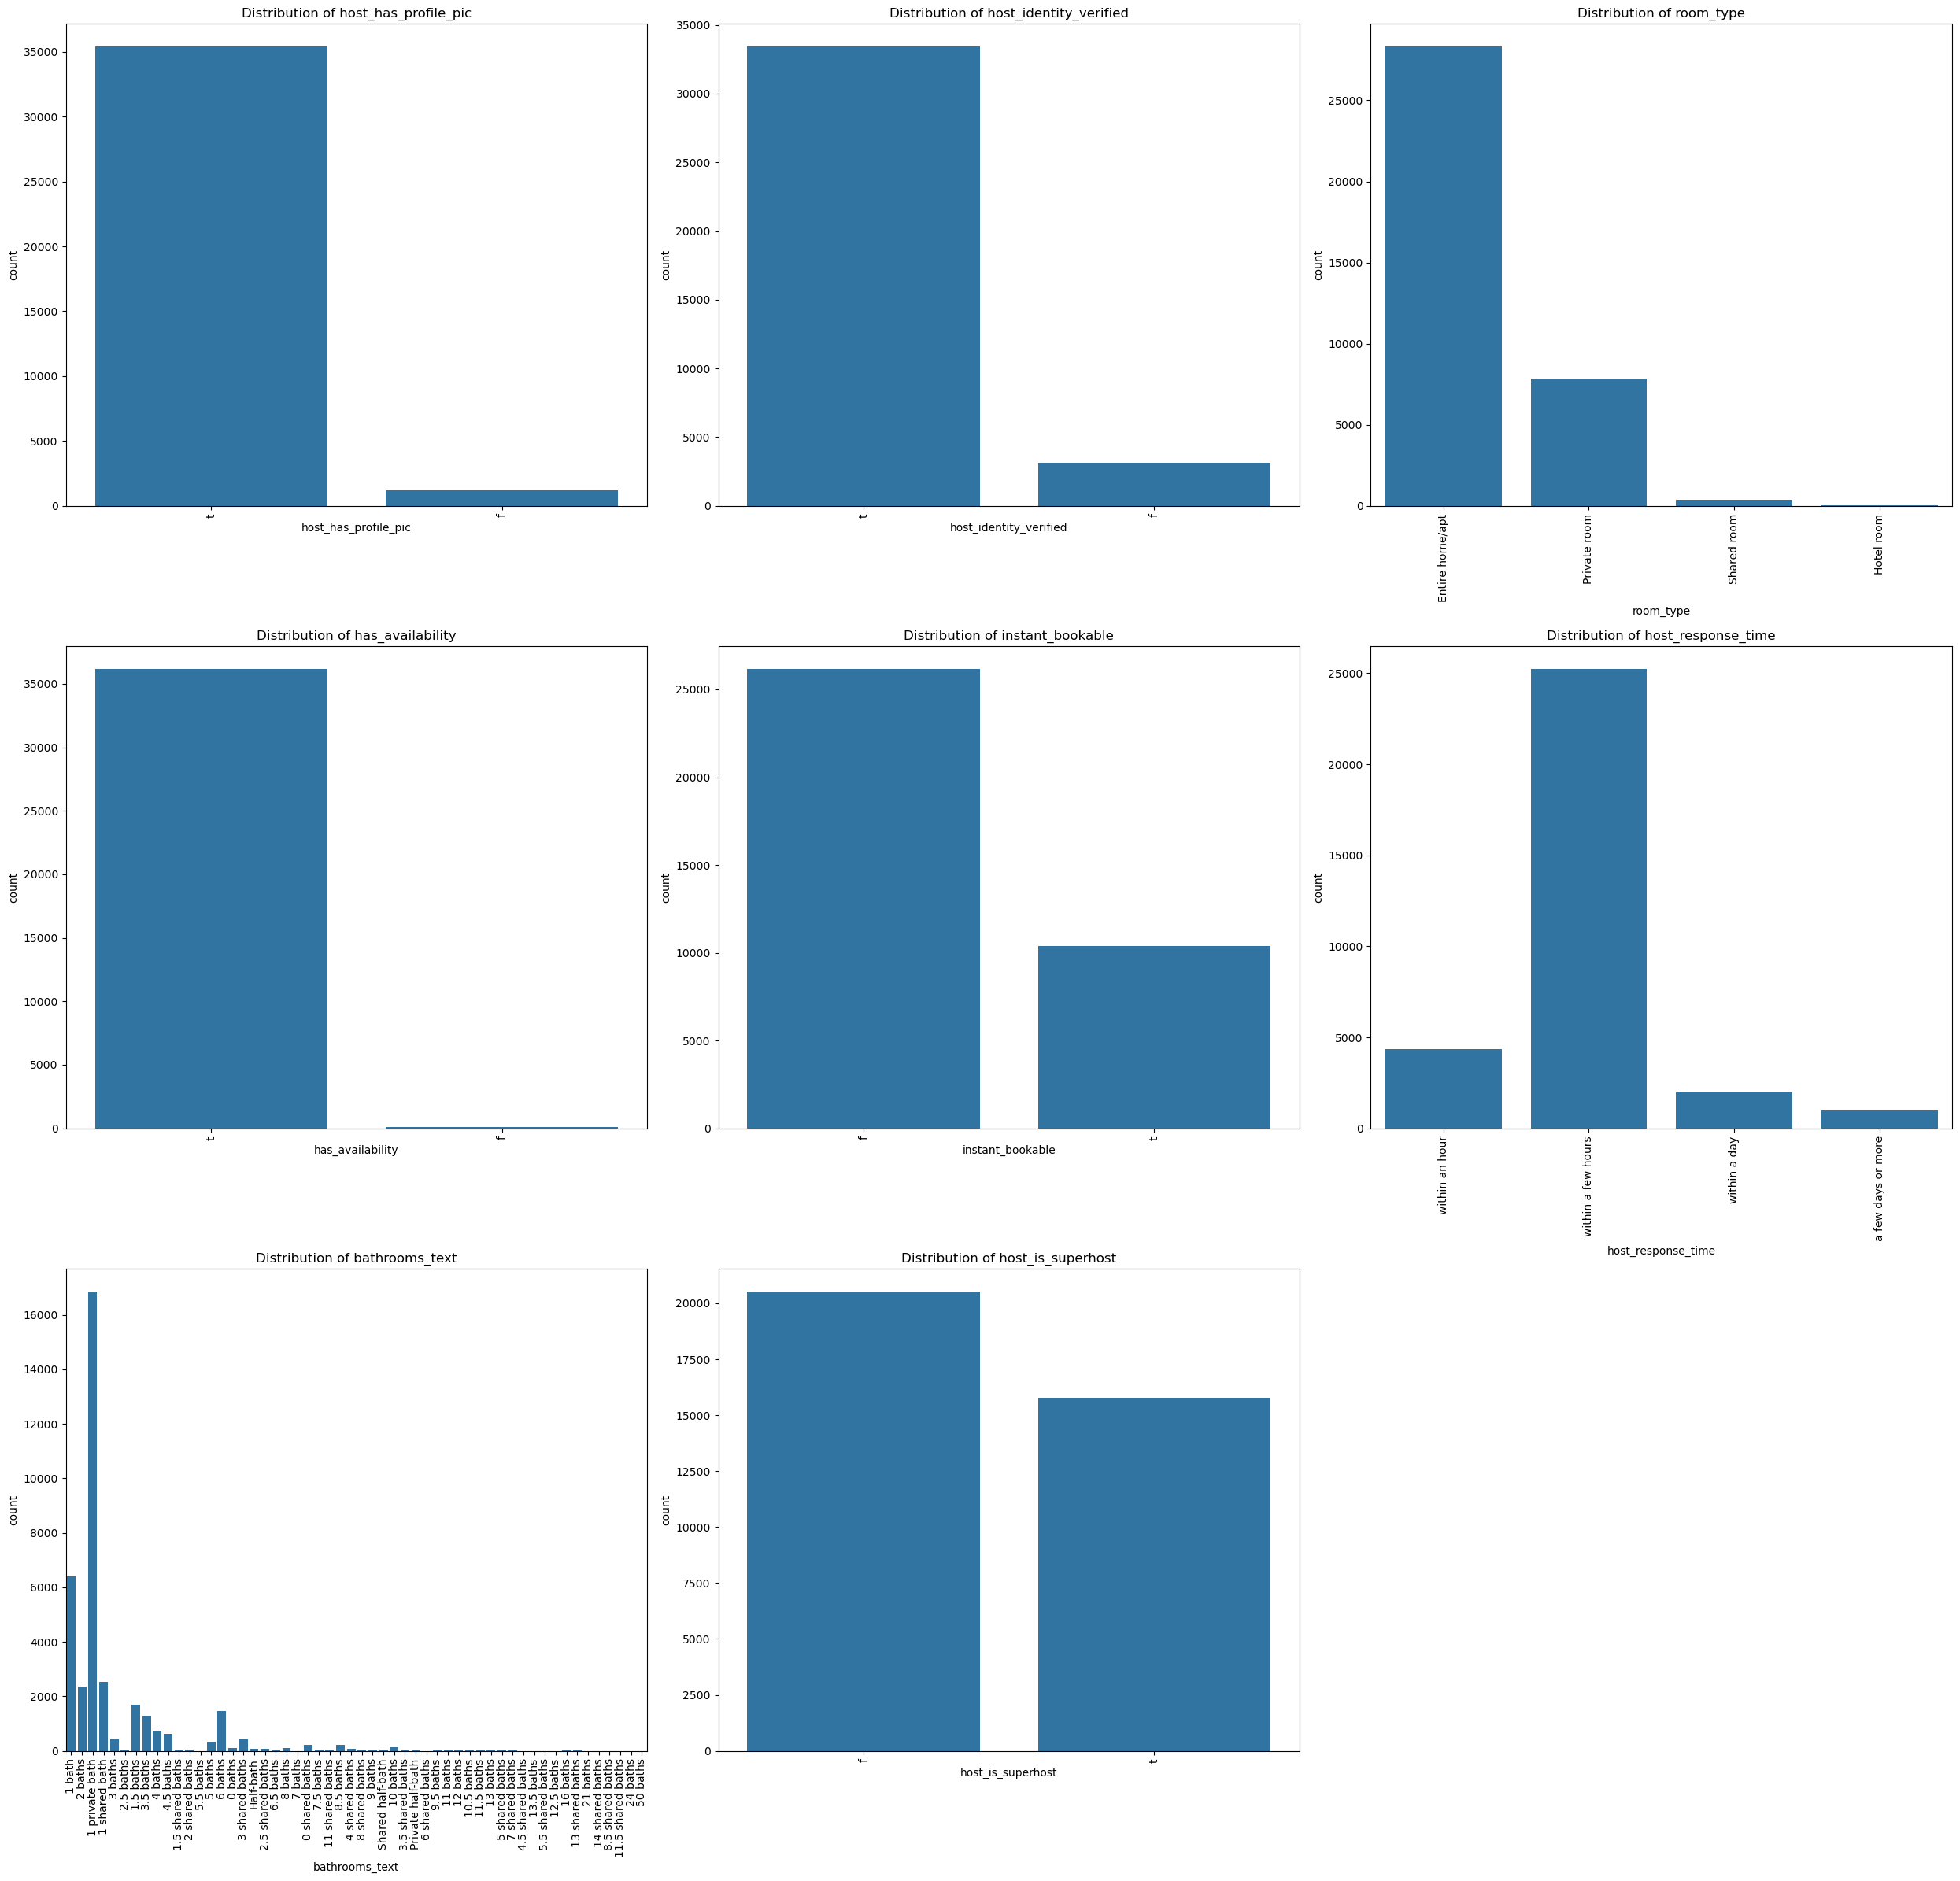

In [34]:
specific_features = ['property_type', 'neighbourhood_cleansed']
other_categorical_features = [feature for feature in categorical_features if feature not in specific_features]

fig, axes = plt.subplots(nrows=1, ncols=len(specific_features), figsize=(15, 8))

for i, feature in enumerate(specific_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90) 

plt.tight_layout()
plt.show()

num_features = len(other_categorical_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 8 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(other_categorical_features):
    sns.countplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xticks(range(len(data[feature].value_counts())))  
    axes[i].set_xticklabels(data[feature].value_counts().index, rotation=90)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Categorical

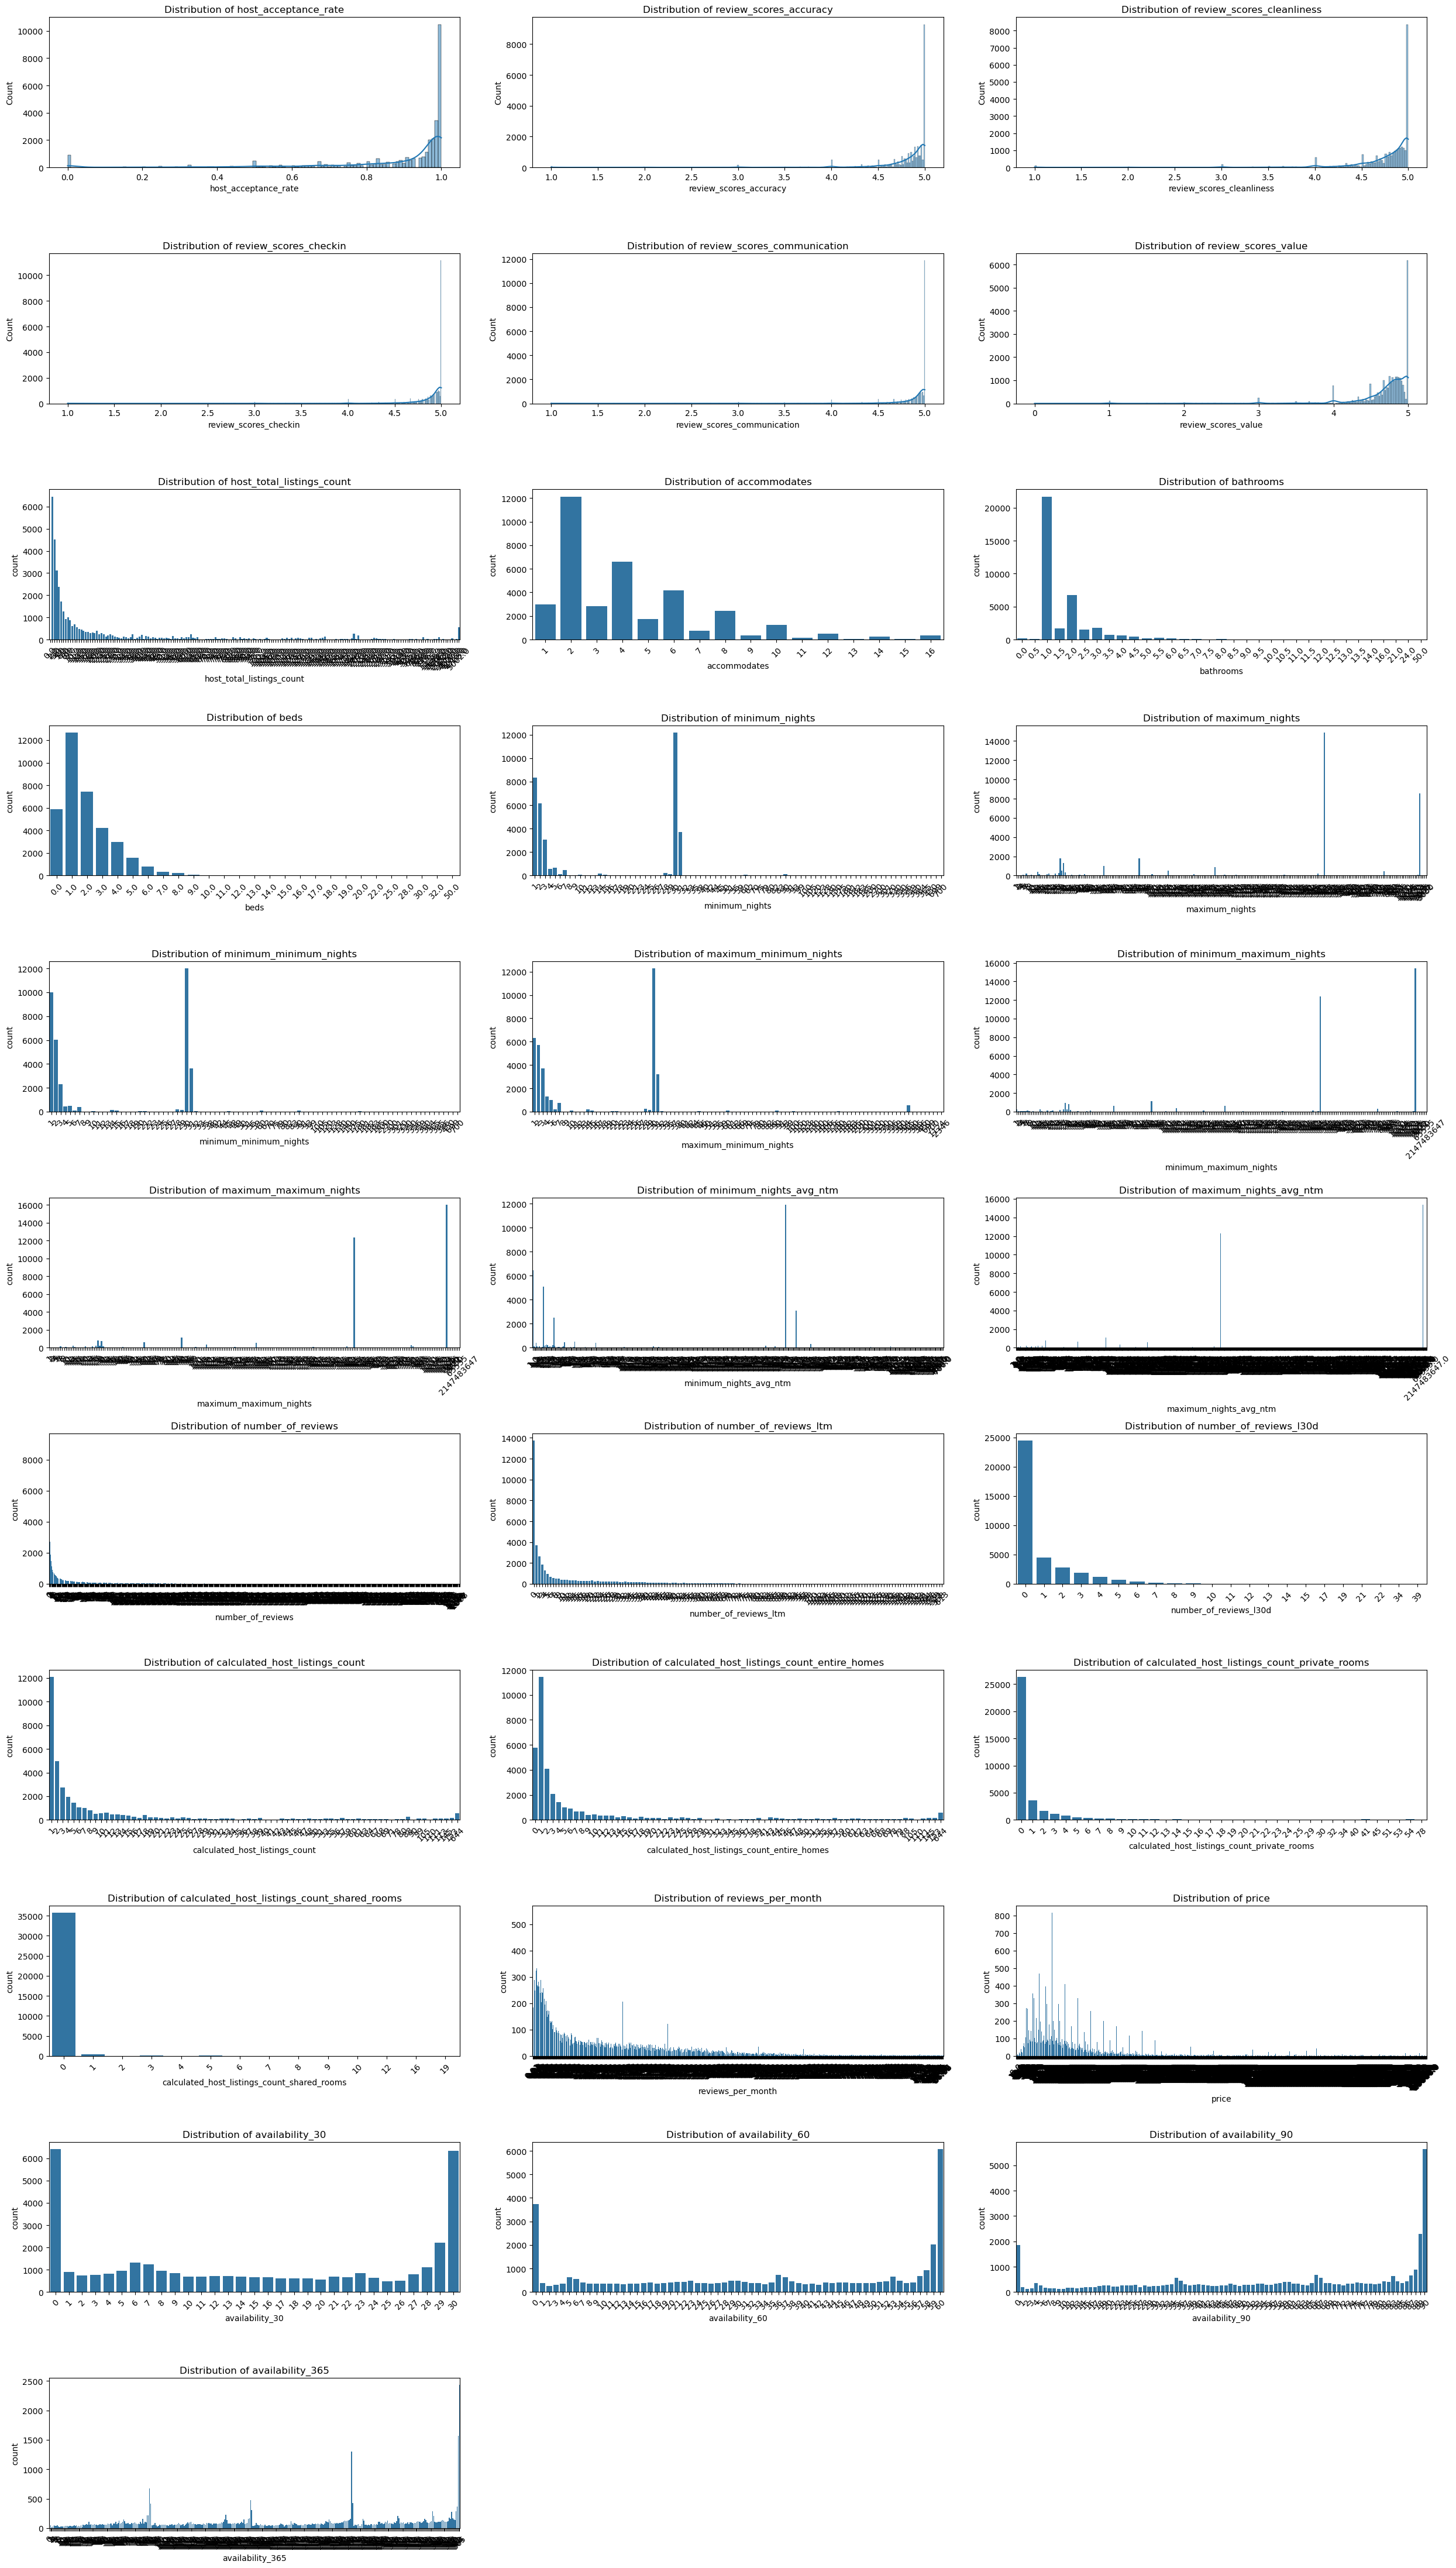

In [35]:
all_features = continuous_features + nominal_features
num_features = len(all_features)
num_columns = 3 
num_rows = (num_features + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(25, 4 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(all_features):
    if feature in continuous_features:
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
    else:
        sns.countplot(x=data[feature], ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
        axes[i].set_xticks(axes[i].get_xticks())  
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Splitting & Preprocessing

#### Dropping non relevant features

In [306]:
data = data.drop(columns=other_features)

#### Splitting to Training, Validation & Testing

In [307]:
# Set a random seed for reproducibility
np.random.seed(42)

# Assuming 'data' is your DataFrame and 'target' is 'review_scores_rating'

# 1. Perform KMeans clustering on 'latitude' and 'longitude'
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['latitude', 'longitude']])

# 2. Get unique clusters
clusters = data['cluster'].unique()

# 3. Randomly select two clusters for validation and testing (ensure they are different)
selected_clusters = np.random.choice(clusters, size=2, replace=False)
cluster_for_test, cluster_for_val = selected_clusters

# 4. Create the test and validation datasets based on the selected clusters
test_data = data[data['cluster'] == cluster_for_test]
val_data = data[data['cluster'] == cluster_for_val]

# 5. Use the remaining data for training
train_data = data[~data['cluster'].isin(selected_clusters)]

# 6. Define your features (X) and target (y) for each set
X_train = train_data.drop(columns=[target, 'cluster'])  # Replace 'review_scores_rating' if your target variable has a different name
y_train = train_data[target]

X_val = val_data.drop(columns=[target, 'cluster'])
y_val = val_data[target]

X_test = test_data.drop(columns=[target, 'cluster'])
y_test = test_data[target]

# 7. Output the shapes of each dataset to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (20505, 52) (20505,)
Validation set shape: (682, 52) (682,)
Test set shape: (15363, 52) (15363,)


#### Imputing and Scaling Data

In [308]:
class TfidfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10):
        self.max_features = max_features
        self.vectorizers = {}

    def fit(self, X, y=None):
        for feature in X.columns:
            vectorizer = TfidfVectorizer(max_features=self.max_features, stop_words='english')
            vectorizer.fit(X[feature].astype(str))
            self.vectorizers[feature] = vectorizer
        return self

    def transform(self, X):
        tfidf_features = []
        for feature, vectorizer in self.vectorizers.items():
            tfidf_transformed = vectorizer.transform(X[feature].astype(str)).toarray()
            tfidf_df = pd.DataFrame(tfidf_transformed, columns=[f"{feature}_tfidf_{i}" for i in range(tfidf_transformed.shape[1])])
            tfidf_features.append(tfidf_df)
        return pd.concat(tfidf_features, axis=1)

In [309]:
preprocessor = ColumnTransformer(transformers=[
    ('continuous', Pipeline(steps=[('scaler', StandardScaler())]), continuous_features),
    ('nominal', Pipeline(steps=[('scaler', MinMaxScaler())]), nominal_features),
    ('categorical', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ]), categorical_features),
    ('tfidf', TfidfTransformer(max_features=10), qualitative_features)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)

print(X_train.shape[0])
print(X_train.shape[1])

20505
409


#### Converting Data Back to DataFrame

In [310]:
def get_column_names(preprocessor, X):
    output_feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'continuous' or name == 'nominal':
            # Continuous or nominal features: no change in feature names
            output_feature_names.extend(columns)
            
        elif name == 'categorical':
            # OneHotEncoder: get the feature names
            encoder = transformer.named_steps['encoder']
            ohe_feature_names = encoder.get_feature_names_out(columns)
            output_feature_names.extend(ohe_feature_names)
        
        elif name == 'tfidf':
            # Custom TfidfTransformer: construct the feature names manually
            for col in columns:
                output_feature_names.extend([f"{col}_tfidf_{i}" for i in range(transformer.max_features)])

    return output_feature_names

In [311]:
# 6. Get all feature names after transformation
transformed_columns = get_column_names(preprocessor, X_train)

# 8. Create a DataFrame with transformed data and new feature names
X_train = pd.DataFrame(X_train, columns=transformed_columns)

# 9. Display the shape and the DataFrame with feature names
print(X_train.shape)

(20505, 409)


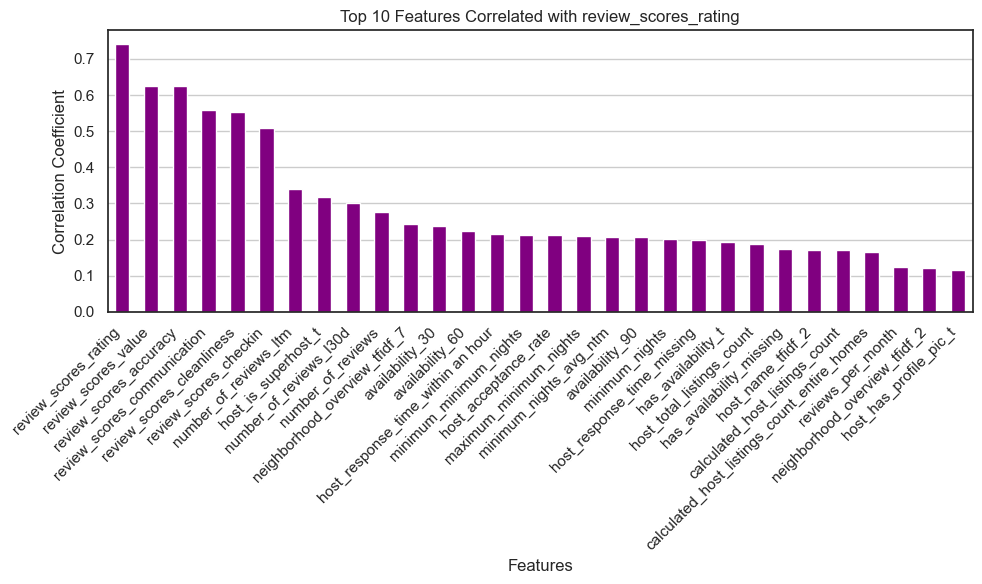

In [312]:
# Step 1: Combine X_train and y_train into a single DataFrame
X_y_train = pd.DataFrame(X_train)  # Ensure X_train is a DataFrame
X_y_train[target] = y_train.values  # Add y_train as a new column

# Step 2: Compute the correlation matrix
correlation_matrix = X_y_train.corr()

# Step 3: Get the correlation of all features with 'review_scores_rating'
correlations_with_target = correlation_matrix[target].drop(target)

# Step 4: Sort by the absolute value of the correlation (most correlated features)
most_correlated_features = correlations_with_target.abs().sort_values(ascending=False)

# Step 5: Get the top 10 most correlated features
top_10_correlated_features = most_correlated_features.head(30)

# Step 6: Create a bar plot for the top 10 correlated features
plt.figure(figsize=(10, 6))
top_10_correlated_features.plot(kind='bar', color='purple')

# Add labels and title
plt.title('Top 10 Features Correlated with review_scores_rating')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()